In [7]:
%matplotlib inline
import numpy as np

In [8]:
x = np.linspace(-10, 10, 100)
y = 1 / (1 + np.exp(- x))

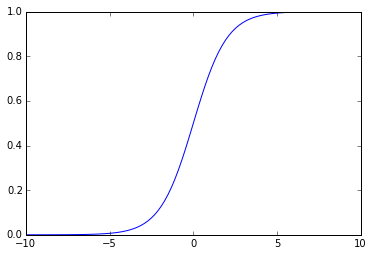

In [9]:
pd.Series(y, index=x).plot()

In [115]:
b0 = -3
b1 = .3
b2 = -.1
nd = 5000
ng = 25
offset = 25

In [116]:
data = []
for i in range(ng):
    max_j = None
    for j in range(nd):
        x1 = i/100; x2 = np.random.normal(scale=.01)
        lp = b0 + x1 * b1 + x2 * b2 + np.random.normal(scale=.01)
        p = 1 / (1 + np.exp(-lp))
        if np.random.uniform() < p:
            max_j = j + 5
        death = 0
        if max_j and j == max_j:
            death = 1
        data.append((i, j, x1, x2, p, death))
        if death > 0:
            break
data = pd.DataFrame(data, columns=['i', 'j', 'x1', 'x2', 'p', 'r'])
data.head()

,i,j,x1,x2,p,r
0,0,0,0,0.009866,0.047186,0
1,0,1,0,-0.000337,0.047866,0
2,0,2,0,0.019123,0.046928,0
3,0,3,0,0.009878,0.047186,0
4,0,4,0,0.004174,0.047783,0


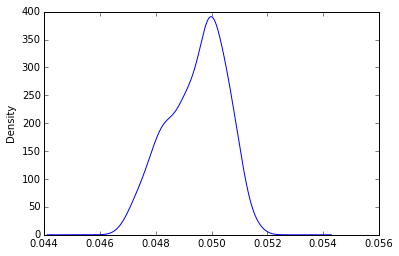

In [117]:
data['p'].plot(kind='kde')

In [124]:
from sklearn.linear_model import LogisticRegression

def prep_data(x, offset):
    x['r_lag'] = x['r'].shift(-1).apply(lambda v: np.nan if v == 0 else v).bfill(limit=offset-1).fillna(0)
    return x

def get_data(d, offset):
    return data.groupby('i').apply(prep_data, offset)


def model_likelihood(X, y, m):
    p = m.predict_proba(X)
    return [ v if y[i] == 1 else 1-v for i, v in enumerate(p) ] 

def get_likelihood(d, offset):
    d = get_data(d, offset)
    X, y = d[['x1', 'x2']], d['r_lag']
    m = LogisticRegression()
    m.fit(X, y)
    y_pred = pd.Series(m.predict(X))
    if len(y_pred.value_counts()) > 1:
        print(offset)
    lk = model_likelihood(X, y, m)
    return np.sum(np.log(lk))
    

11
12
13
14
15
16
17
18
19
20
21
22


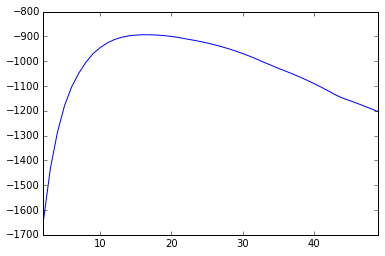

In [125]:
offsets = np.arange(2, 50)
lks = pd.Series([get_likelihood(data, o) for o in offsets], index=offsets)
lks.plot()